In [1]:
from autoencoders import *
from pdb_utils import *

import pickle
import numpy as np
import pandas as pd
import random

import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from functools import partial
import sys

from Bio import PDB
import numpy as np
import os
import cv2

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time

In [2]:
with open('pdb_groups.pkl', 'r') as f:
    pdb_groups = pickle.load(f)

In [9]:
groups = filter(lambda x: 20>=len(x[1])>=10, pdb_groups.items())

In [10]:
print len(map(lambda x: x[0],groups))

200


In [11]:
# Total number of pdbs: 2765

2765


In [13]:
with open('label_dict.pkl', 'rb') as f:
    label_dict = pickle.load(f)

def nice_time(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Runtime: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [14]:
s_time = time.time()
structures = []

for group, l in groups:
    for pdb in l:
        try:
            pdb_path = os.path.join("PDBs", pdb+".pdb")
            parser = PDB.PDBParser()
            structure = parser.get_structure(pdb, pdb_path)
            structures.append(structure)
        except:
            continue
end = time.time()
nice_time(s_time,end)

Runtime: 00:36:38.77


In [15]:
print("\nCreating protein contact maps")
s_time = time.time()
proteinmatrixdict = ProteinContactMapDict(structures, resize_to=(64,64), removeSymmetry=True)
end = time.time()
nice_time(s_time,end)


Creating protein contact maps
Runtime: 01:18:13.83


In [16]:
labels, features = list(proteinmatrixdict.keys()), list(proteinmatrixdict.values())
input_size = len(features[0])
print("Number of pdbs: %d"%len(structures))
print("Input size: %d"%input_size)

Number of pdbs: 2765
Input size: 2016


In [17]:
print("\nLinear Autoencoder - 100 epochs")
s_time = time.time()
new_features, loss = LinearAutoencoder(features, input_size, 500, 100, learning_rate=0.0001)
end = time.time()
nice_time(s_time,end)


Linear Autoencoder - 100 epochs
Runtime: 00:15:43.59


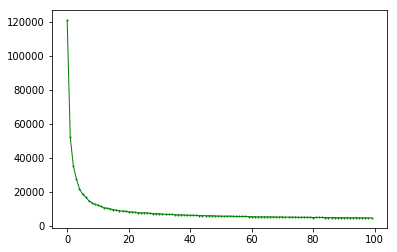

In [18]:
# LOSS GRAPH
fig, ax = plt.subplots()
ax.plot(range(0,len(loss)), loss, 'go-', linewidth=1, markersize=1)
fig.savefig("loss_figure.png")

In [19]:
with open("LASTnewfeatures.pkl","w") as f:
    pickle.dump(new_features, f)

In [21]:
with open("LASTproteinmatrixdict.pkl","w") as f:
    pickle.dump(proteinmatrixdict, f)

# Family Level Classification

In [52]:
# Encoding labels
y = []
for pdb_ in labels:
    y.append(label_dict[pdb_])
a = list(set(y))
group2id = dict(zip(a, range(len(a))))
y_ = list(map(lambda x: group2id[x], y))

In [53]:
y = np.array(y_)

In [54]:
# Stratified Cross Validation
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
C = 1
acc, prec, rec = 0,0,0
s_time = time.time()
for train_index, test_index in sss.split(new_features, y):
    print("Stratified Cross Validation - %d"%C)
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Random Forest Classifier - Training")
    # Fitting Random Forest Classification to the Training set
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
    classifier.fit(X_train, y_train)
    # Predicting the Test set results
    print("Random Forest Classifier - Testing")
    y_pred = classifier.predict(X_test)
    acc+=accuracy_score(y_test, y_pred)
    prec+=precision_score(y_test, y_pred, average='weighted')
    rec+=recall_score(y_test, y_pred, average='weighted')
    C+=1
end = time.time()
nice_time(s_time,end)

print("\naverage accuracy_score:", acc/10)
print("average precision_score: ", prec/10)
print("average recall_score: ", rec/10)

Stratified Cross Validation - 1
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 2
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 3
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 4
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 5
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 6
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 7
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 8
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 9
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 10
Random Forest Classifier - Training
Rand

# Fold Level Classification

In [55]:
# Encoding labels
folds = []
for pdb_ in labels:
    folds.append(".".join(label_dict[pdb_].split(".")[:2]))
a = list(set(folds))
print len(a)
group2id = dict(zip(a, range(len(a))))
y = np.array(list(map(lambda x: group2id[x], folds)))

122


In [56]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
C = 1
acc, prec, rec = 0,0,0
s_time = time.time()
for train_index, test_index in sss.split(new_features, y):
    print("Stratified Cross Validation - %d"%C)
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Random Forest Classifier - Training")
    # Fitting Random Forest Classification to the Training set
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
    classifier.fit(X_train, y_train)
    # Predicting the Test set results
    print("Random Forest Classifier - Testing")
    y_pred = classifier.predict(X_test)
    acc+=accuracy_score(y_test, y_pred)
    prec+=precision_score(y_test, y_pred, average='weighted')
    rec+=recall_score(y_test, y_pred, average='weighted')
    C+=1
end = time.time()
nice_time(s_time,end)

print("\naverage accuracy_score:", acc/10)
print("average precision_score: ", prec/10)
print("average recall_score: ", rec/10)

Stratified Cross Validation - 1
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 2
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 3
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 4
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 5
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 6
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 7
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 8
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 9
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 10
Random Forest Classifier - Training
Rand

# Class Level Classification

In [57]:
# Encoding labels
folds = []
for pdb_ in labels:
    folds.append(label_dict[pdb_].split(".")[0])
a = list(set(folds))
print len(a)
group2id = dict(zip(a, range(len(a))))
y = np.array(list(map(lambda x: group2id[x], folds)))

7


In [58]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
C = 1
acc, prec, rec = 0,0,0
s_time = time.time()
for train_index, test_index in sss.split(new_features, y):
    print("Stratified Cross Validation - %d"%C)
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Random Forest Classifier - Training")
    # Fitting Random Forest Classification to the Training set
    classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
    classifier.fit(X_train, y_train)
    # Predicting the Test set results
    print("Random Forest Classifier - Testing")
    y_pred = classifier.predict(X_test)
    acc+=accuracy_score(y_test, y_pred)
    prec+=precision_score(y_test, y_pred, average='weighted')
    rec+=recall_score(y_test, y_pred, average='weighted')
    C+=1
end = time.time()
nice_time(s_time,end)

print("\naverage accuracy_score:", acc/10)
print("average precision_score: ", prec/10)
print("average recall_score: ", rec/10)

Stratified Cross Validation - 1
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 2
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 3
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 4
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 5
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 6
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 7
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 8
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 9
Random Forest Classifier - Training
Random Forest Classifier - Testing
Stratified Cross Validation - 10
Random Forest Classifier - Training
Rand

# Previous codes

In [205]:
X_train, y_train = map(lambda x: x[0], training_set), map(lambda x: x[1], training_set)
X_test, y_test = map(lambda x: x[0], test_set), map(lambda x: x[1], test_set)

In [206]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [207]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [208]:
print "accuracy_score: ", accuracy_score(y_test, y_pred)
print "precision_score: ", precision_score(y_test, y_pred, average='weighted')
print "recall_score: ", recall_score(y_test, y_pred, average='weighted')

accuracy_score:  0.9310344827586207
precision_score:  0.9379310344827586
recall_score:  0.9310344827586207


In [209]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [210]:
# Predicting the Test set results
y_pred = neigh.predict(X_test)

print "accuracy_score: ", accuracy_score(y_test, y_pred)
print "precision_score: ", precision_score(y_test, y_pred, average='weighted')
print "recall_score: ", recall_score(y_test, y_pred, average='weighted')

accuracy_score:  0.9655172413793104
precision_score:  0.9673321234119782
recall_score:  0.9655172413793104
